In [1]:
!pip install -q rioxarray


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git

In [74]:
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '2' #cannot work

In [75]:
import numpy as np
from scipy.ndimage import label
from PIL import Image
import rioxarray
import xarray as xr
import matplotlib.pyplot as plt
import os
from pathlib import Path

In [76]:
import torch

In [77]:
from tqdm import tqdm

In [78]:
# from https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/SAM/Fine_tune_SAM_(segment_anything)_on_a_custom_dataset.ipynb
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  z, y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = max(np.min(x_indices),0), min(np.max(x_indices),511)
  y_min, y_max = max(np.min(y_indices),0), min(np.max(y_indices),511)
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [79]:
imagedir = Path('/home/data/kenya/images/')
maskdir = Path('/home/data/kenya/labels/')

In [80]:
buildingdir = Path('/home/data/kenya-binary-masks/buildings/')
cropsdir = Path('/home/data/kenya-binary-masks/crop_fields/')

In [81]:
image_files = os.listdir('/home/data/kenya/images/')
mask_files = os.listdir('/home/data/kenya/labels/')

In [82]:
def get_bboxes(mask_file):
    crop_bboxes = []
    building_bboxes = []
    example_groundtruth = rioxarray.open_rasterio(mask_file)
    building_groundtruth = xr.where(example_groundtruth % 2 == 1, 1, 0)
    field_groundtruth = xr.where(example_groundtruth==2, 1, 0)
    
    building_masks, building_num_labels = label(building_groundtruth)
    for i in range(1, building_num_labels + 1):
        building_object_mask = xr.where(building_masks == i, 1, 0)
        bbox = get_bounding_box(building_object_mask)
        building_bboxes.append(bbox)
        
    field_masks, field_num_labels = label(field_groundtruth)
    for i in range(1, field_num_labels + 1):
        field_object_mask = xr.where(field_masks == i, 1, 0)
        bbox = get_bounding_box(field_object_mask)
        crop_bboxes.append(bbox)
    return building_bboxes, crop_bboxes

In [83]:
building_bboxes, crop_bboxes = get_bboxes('/home/data/kenya/labels/kenol1_1001.tif')

In [84]:
building_bboxes

[[484, 3, 511, 117],
 [0, 49, 26, 91],
 [32, 59, 134, 112],
 [139, 76, 297, 227],
 [0, 188, 38, 235]]

In [85]:
img = Image.open(imagedir / 'kenol1_1001.tif').convert("RGB")

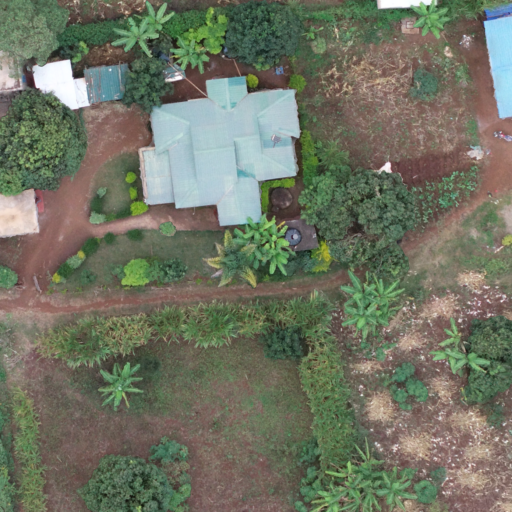

In [61]:
img

In [36]:
from transformers import SamModel, SamProcessor

In [37]:
model = SamModel.from_pretrained("facebook/sam-vit-base").to(0)
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [62]:
crop_inputs = processor(img, input_boxes=[crop_bboxes], return_tensors="pt").to(0)
building_inputs = processor(img, input_boxes=[building_bboxes], return_tensors="pt").to(0)

In [63]:
crop_outputs = model(**crop_inputs)

In [64]:
building_outputs = model(**building_inputs)

In [65]:
crop_masks = processor.image_processor.post_process_masks(crop_outputs.pred_masks.cpu(), crop_inputs["original_sizes"].cpu(), crop_inputs["reshaped_input_sizes"].cpu())

In [66]:
building_masks = processor.image_processor.post_process_masks(building_outputs.pred_masks.cpu(), building_inputs["original_sizes"].cpu(), building_inputs["reshaped_input_sizes"].cpu())

In [67]:
del crop_inputs, building_inputs, crop_outputs, building_outputs

In [68]:
torch.cuda.empty_cache()

In [69]:
building_mask = torch.any(building_masks[0], 0)[:1,:,:]
crop_mask = torch.any(crop_masks[0], 0)[:1,:,:]

In [70]:
building_mask.shape

torch.Size([1, 512, 512])

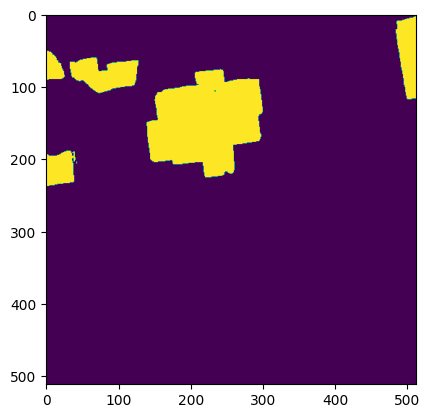

In [71]:
plt.imshow(  torch.any(building_masks[0], 0)[:1,:,:].permute(1, 2, 0).cpu().numpy().astype('uint8')  )

In [72]:
building_binary = torch.where(building_mask, 1, 0)
sam_mask = torch.where(crop_mask, 2, building_binary)

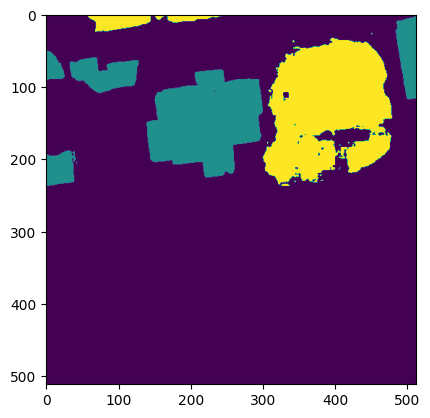

In [73]:
plt.imshow(sam_mask.permute(1,2,0).cpu().numpy())
plt.show()